Adversarial examples generated by the latest `torchattacks` do not seem to have (strong) noises, as it employs early stopping of adversarial attacks. For better visualization, we employ APGD in `auto-attack` with a specific argument (`best_loss=True`).

P.S. Even in `torchattacks`, `torchattacks.apgd.APGD.perturb(x, y, best_loss=True)` enables the similar work.

In [1]:
import os
import sys

root = os.path.join('..')
sys.path.append(root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as TF
import torchvision
import torchvision.transforms.functional as VF
from autoattack.autopgd_base import APGDAttack
from torchvision.models import ResNeXt50_32X4D_Weights, resnext50_32x4d

from utils.utils import ModelWithNormalization, freeze, read_labels

In [3]:
device = 'cuda:0'
use_japanese_labels = False
if use_japanese_labels:
    import japanize_matplotlib

# Attack

In [4]:
# setup model
weights = ResNeXt50_32X4D_Weights.IMAGENET1K_V2
model = resnext50_32x4d(weights=weights)
model = model.eval()
freeze(model)
model = ModelWithNormalization(model, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
model.to(device)

# ImageNet labels
fname = 'imagenet_labels.jp.txt' if use_japanese_labels else 'imagenet_labels.en.txt'
label_path = os.path.join(root, 'labels', fname)
labels = read_labels(label_path)
labels = np.array(labels)

# read imgs
clean_img_list = []
img_root = os.path.join(root, 'imgs')
img_size = 224
fnames = os.listdir(img_root)
for fname in fnames:
    p = os.path.join(img_root, fname)
    clean_img = torchvision.io.read_image(p)
    clean_img = VF.center_crop(clean_img, min(clean_img.shape[1:])) # type: ignore
    clean_img = VF.resize(clean_img, [img_size, img_size], antialias=True)
    clean_img_list.append(clean_img)
clean_imgs = torch.stack(clean_img_list) # (*, 3, img_size, img_size)
clean_imgs = clean_imgs / 255

# prediction for clean imgs
clean_imgs = clean_imgs.to(device)
clean_probs = TF.softmax(model(clean_imgs), dim=1)
clean_indices = clean_probs.max(dim=1).indices
clean_labels = labels[clean_indices.cpu()]

# attack
eps_str_list = ['8', '16', '24', '32', '64']
eps_list = [8/255, 16/255, 24/255, 32/255, 64/255]
advs_dict = {}
adv_probs_dict = {}
adv_indices_dict = {}
adv_labels_dict = {}
for eps in eps_list:
    atk = APGDAttack(model, eps=eps, seed=0, use_largereps=eps>8/255)
    advs_dict[eps] = atk.perturb(clean_imgs, clean_indices, best_loss=True).detach()
    adv_probs_dict[eps] = TF.softmax(model(advs_dict[eps]), dim=1)
    adv_indices_dict[eps] = adv_probs_dict[eps].max(dim=1).indices
    adv_labels_dict[eps] = labels[adv_indices_dict[eps].cpu()]

# Show

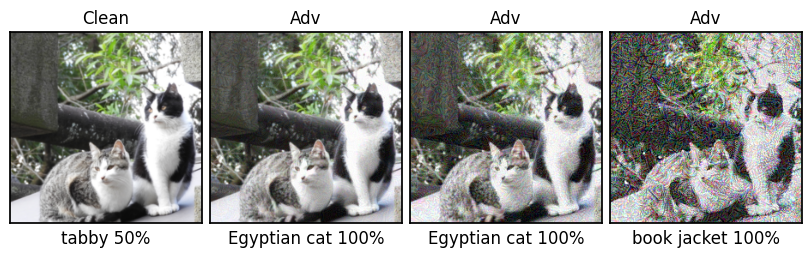

In [5]:

sns.set_context('notebook', 1)

scale = 1
use_img_idx = 0
use_eps_indices = [0, 2, 4]
ncol = len(use_eps_indices) + 1

figsize = (8, 14)
fig, axes = plt.subplots(1, ncol, figsize=figsize, layout='constrained')

for c in range(ncol):
    ax = axes[c]

    if c == 0:
        img = clean_imgs[use_img_idx]
        label = clean_labels[use_img_idx]
        label_idx = clean_indices[use_img_idx]
        prob = clean_probs[use_img_idx]
    else:
        use_eps_idx = use_eps_indices[c-1]
        eps = eps_list[use_eps_idx]
        img = advs_dict[eps][use_img_idx]
        label = adv_labels_dict[eps][use_img_idx]
        label_idx = adv_indices_dict[eps][use_img_idx]
        prob = adv_probs_dict[eps][use_img_idx]

    img = img.cpu().permute(1, 2, 0)
    ax.imshow(img)

    prob = int(prob[label_idx].item() * 100)

    ax.set_xlabel(label + f' {prob}%')
    ax.tick_params(bottom=False, labelbottom=False)
    ax.tick_params(left=False, labelleft=False)

axes[0].set_title('Clean')
axes[1].set_title('Adv')
axes[2].set_title('Adv')
axes[3].set_title('Adv')

plt.show()